# Question 3

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
import math

In [6]:
def brownian_bridge_path(level, Z, M):
    num_time_steps = M ** level
    if num_time_steps <= 1:
        return np.array([Z[0] * math.sqrt(T)])
    
    dt = T / (num_time_steps - 1)
    B = np.zeros(num_time_steps + 1)

    B[0] = 0
    B[-1] = Z[0] * math.sqrt(T)

    step = num_time_steps // 2
    index = 1

    while step > 0:
        for i in range(step, num_time_steps, 2 * step):
            ti_minus_1, ti, ti_plus_1 = (i - step) * dt, i * dt, (i + step) * dt
            left = B[i - step]
            right = B[i + step]

            mean = ((ti_plus_1 - ti) * left + (ti - ti_minus_1) * right) / (ti_plus_1 - ti_minus_1)
            variance = (ti_plus_1 - ti) * (ti - ti_minus_1) / (ti_plus_1 - ti_minus_1)

            B[i] = mean + Z[index] * math.sqrt(variance)
            index += 1

        step //= 2

    return B[1:]

In [3]:
def stock_path(S0, level, M=4):
    """
    Simulates a stock path according to the Euler discretization of the CIR model.
    
    INPUT:
        S0 (float): price of a stock at time 0. 
        level (int): level of discretization
        M (int): constant related to discretization
    
    OUTPUT:
        (array): stock path
    """
    num_time_steps = M ** level
    dt_level = T / num_time_steps
    Z = np.random.normal(size=num_time_steps + 1)
    B_path = brownian_bridge_path(level, Z, M)

    S = [S0]
    S_t = S0
    for i in range(num_time_steps - 1):
        dW = B_path[i + 1] - B_path[i]
        dS_t = a * (b - S_t) * dt_level + sigma * math.sqrt(S_t) * dW + 0.5 * sigma**2 * (dW**2 - dt_level)
        S_t += dS_t
        S.append(S_t)

    return S

In [41]:
# Define model parameters

T=1
a, b, sigma, S0, K = 0.15, 1, 0.2, 5, 4
r=0.05

### Path samples

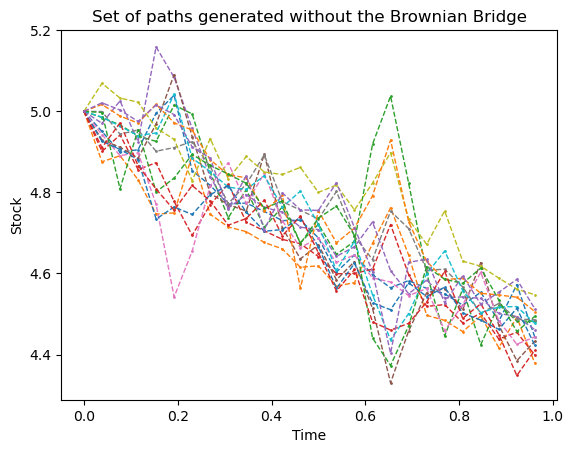

In [54]:
n_samples=15

for _ in range(n_samples):
    path = stock_path(S0, level=3, M=3)
    time_axis = np.linspace(0, T, len(path))
    plt.plot(time_axis[:-1], path[:-1], linewidth=1, linestyle='--', marker='o', markersize=1)

plt.title("Set of paths generated without the Brownian Bridge")
plt.ylabel('Stock') 
plt.xlabel('Time') 
plt.show()

In [11]:
def estimate_variance(f, level, N_l):
    """
    Returns the estimated variance according to the equation from the paper of Giles
    """
    fine_samples = [np.nan_to_num(f(stock_path(S0, level, M=4),K)) for _ in range(N_l)]   #computes N_l estimates of Pl_hat_i
    coarse_samples = [np.nan_to_num(f(stock_path(S0, level-1, M=4),K))
                      for _ in range(N_l)] if level > 0 else [0] * N_l                    #computes N_l estimates of P_{l-1}_hat_i
    diff_samples = np.array(fine_samples) - np.array(coarse_samples)                      #computes the terms of the telescopic sum
    return np.var(diff_samples)

In [12]:
def standard_monte_carlo(f, L, no_of_paths):
    """
        Function computing payoffs using standard Monte Carlo

    INPUT:
    f : function
        The function to be aproximated.

    OUTPUT:

    """
    payoffs = [np.nan_to_num(f(stock_path(S0, level=L, M=3),K)) for _ in range(no_of_paths)]
    return payoffs

In [13]:
def payoff_call(S, K):
    """
    Returns the payoff of the Asian Call option
    """
    return np.maximum(np.mean(S)-K, 0)* np.exp(-r * T)
    
def payoff_put(S, K):
    """
        Returns the payoff of the Asian Put option
    """
    return np.maximum(K-np.mean(S), 0)* np.exp(-r * T)

## Multi-Level MC Method with Brownian Bridge

In [30]:
import numpy as np

def mlmc(f, eps, M):
    """
    Multilevel Monte Carlo algorithm for computing E[f], where f is an expensive-to-evaluate function.
    
    Parameters:
    -----------
    f : function
        The function to be aproximated.
    L : int
        The number of levels of refinement.
    eps : float
        The desired accuracy of the estimator.
   
    
    Returns:
    --------
    P_0 : float
        The estimated value of f.
        
    V_L_hat : float
        The estimated variance of f.
    """
    L = 1
    converged = False
    V_L_sum = []
    
    Y_hat, V_L_hat = 0, 0
    P_0 = 0
    
    while not converged:
        
        V_L_sum = [estimate_variance(f, level=l, N_l=10**4) for l in range(L + 1)] #estimate variance to compute Nl
    
        hl = [T /np.power(M,l) for l in range(L + 1)]
        sum_sqrt_var_hl = sum([np.sqrt(V_L_sum[l] / hl[l]) for l in range(L + 1)])
    
        sample_sizes = [np.minimum(int(np.ceil(2 * (eps**-2) *
                                      np.sqrt(V_L_sum[l] * hl[l]) 
                                                * sum_sqrt_var_hl)),10**6) for l in range(L + 1)]
        
        if sample_sizes[L]==10**6:
            print("***** Maximum Number of Samples Is Achieved *****")
        
        
        print("Level:",L)
        print("Number of samples:",sample_sizes[L])
    
        if L<2:

            payoffs = []
            for _ in range(sample_sizes[L]):
                payoffs.append(f(stock_path(S0, level=L, M=4),K))

            Y_hat = np.mean(payoffs) # current level
            V_L_sum[L] = np.var(payoffs) #re-estimate the variance
            V_L_hat += V_L_sum[-1]/sample_sizes[L] # compute the total variance

            P_0 = Y_hat
            Y_l_1 = Y_hat
            L+=1

        elif L>=2 and not converged:
            
            payoffs = []
            payoffs_1 = []
            prod = 0
            for i in range(L):
                prod+=np.sqrt(V_L_sum[i]*T/np.power(M,i))


            for _ in range(sample_sizes[L]):
                S_L = stock_path(S0, level=L, M=4)
                S_L_1 = S_L[::M]
                payoffs.append(np.nan_to_num(f(S_L,K)))
                payoffs_1.append(np.nan_to_num(f(S_L_1,K)))

            Y_l_1 = np.mean(payoffs_1)  # coarser level   
            Y_hat = np.mean(payoffs) # current level
            P_0 += Y_hat-Y_l_1 # estimator
            V_L_sum[L] = np.var(payoffs) #re-estimate the variance
            V_L_hat += V_L_sum[-1]/sample_sizes[L] # compute the total variance

            if abs(Y_hat-Y_l_1)<1/np.sqrt(2)*(M**2-1)*eps:
                
                converged = True
                
            else:
                
                L+=1
                
        print("Payoff:", Y_hat)
        print("Variance:", V_L_hat)    

    return P_0, V_L_hat

In [15]:
a, b, sigma, S0, K = 0.15, 0.2, 0.3, 5, 4
comp_time = []
arr_res = []
cpu_time = 0
for m in range(2, 10):
    for _ in range(5):
        start_time = time.process_time()
        res = mlmc(f=payoff_call, eps=0.005, M=m)  # Assign the result to a variable
        print(f"Result for M={m}: {res}")  # Print the result for each M
        end_time = time.process_time()
        cpu_time += (end_time - start_time)
    avg_cpu_time = cpu_time / 5
    print("************************************************")
    print(f"Computational time for M={m}: {avg_cpu_time}")
    comp_time.append(avg_cpu_time)
    print(comp_time)
    cpu_time = 0
    print("************************************************")

Level: 1
Number of samples: 7390
Payoff: 0.702996505536631
Variance: 1.2651564010720482e-05
Level: 2
Number of samples: 23549
Payoff: 0.6474060887962881
Variance: 1.7224242478517652e-05
Level: 3
Number of samples: 35035
Payoff: 0.6358927540246857
Variance: 2.0397104292841407e-05
Result for M=2: (0.6795372087986576, 2.0397104292841407e-05)
Level: 1
Number of samples: 7434
Payoff: 0.7047362680193952
Variance: 1.2317535445208938e-05
Level: 2
Number of samples: 23871
Payoff: 0.6502064945994624
Variance: 1.6852961228596526e-05
Level: 3
Number of samples: 34181
Payoff: 0.6322785315992687
Variance: 2.008087181271552e-05
Result for M=2: (0.6812934343049231, 2.008087181271552e-05)
Level: 1
Number of samples: 7243
Payoff: 0.7000612946386865
Variance: 1.2554866360745704e-05
Level: 2
Number of samples: 23621
Payoff: 0.6462296137619833
Variance: 1.711254667749399e-05
Level: 3
Number of samples: 34548
Payoff: 0.6336169539293021
Variance: 2.0334247273997646e-05
Result for M=2: (0.6762767869692604, 2.

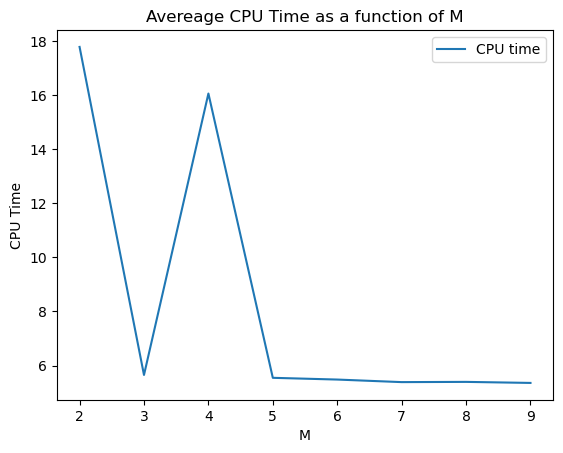

In [28]:
plt.plot(range(2,10),comp_time, label="CPU time")
plt.title('Avereage CPU Time as a function of M') 
plt.ylabel('CPU Time') 
plt.xlabel('M') 
plt.legend()
plt.show()

In [33]:
a, b, sigma, S0, K = 0.15, 0.2, 0.3, 5, 4
comp_time = []
arr_res = []
cpu_time = 0
variance_values = 0
for _ in range(10):
    start_time = time.process_time()
    res = mlmc(f=payoff_call, eps=0.005, M=5)  # Assign the result to a variable
    end_time = time.process_time()
    cpu_time += (end_time - start_time)
    variance_values += res[1]
print("************************************************")
avg_cpu_time = cpu_time / 10
print(f"Computational time for M=6: {avg_cpu_time}")
comp_time.append(avg_cpu_time)
print(comp_time)
print(variance_values/10)
cpu_time = 0
print("************************************************")

Level: 1
Number of samples: 7501
Payoff: 0.7045467098940289
Variance: 1.2412565623209297e-05
Level: 2
Number of samples: 20825
Payoff: 0.6456252207196329
Variance: 1.7515012207988527e-05
Level: 1
Number of samples: 7343
Payoff: 0.7036645688552814
Variance: 1.2480738150566547e-05
Level: 2
Number of samples: 20769
Payoff: 0.647781362104711
Variance: 1.7575313162662557e-05
Level: 1
Number of samples: 7098
Payoff: 0.7059536835115674
Variance: 1.3321571527625165e-05
Level: 2
Number of samples: 20624
Payoff: 0.6425342190037742
Variance: 1.84406882740682e-05
Level: 1
Number of samples: 7435
Payoff: 0.7043953007392404
Variance: 1.23911898673268e-05
Level: 2
Number of samples: 20602
Payoff: 0.6519490766422331
Variance: 1.7676105044332256e-05
Level: 1
Number of samples: 7406
Payoff: 0.7102687534556259
Variance: 1.2419083884674198e-05
Level: 2
Number of samples: 20628
Payoff: 0.6472494250430484
Variance: 1.7682474862259013e-05
Level: 1
Number of samples: 7345
Payoff: 0.7018741980158267
Variance: 

In [17]:
a, b, sigma, S0, K = 0.15, 0.2, 0.2, 5, 4
mc_res = standard_monte_carlo(f=payoff_call, L=3, no_of_paths=100000)

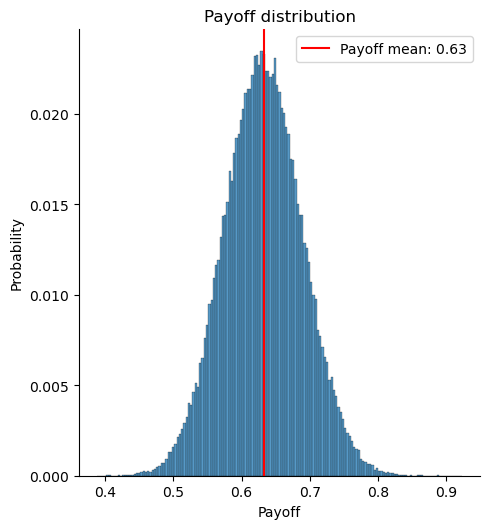

In [27]:
sns.displot(mc_res, stat='probability')
plt.title('Payoff distribution')
plt.xlabel('Payoff')
payoff_mean=np.mean(mc_res)
plt.axvline(x=payoff_mean, color="red", label="Payoff mean: "+str(round(payoff_mean, 2)))
plt.legend()
plt.show()

In [19]:
np.mean(mc_res), np.var(mc_res)

(0.6321364252554924, 0.0032795167305882064)

In [25]:
mlmc_cpu_time = 7 # Comparison with the CPU obtained for the MLMC without Brownian Bridge
elapsed_time = 0

paths = 500

while elapsed_time < mlmc_cpu_time:
    start_time = time.process_time()
    mc_estimates = []
    for _ in range(100):
        mc_estimates.append(np.mean(standard_monte_carlo(f=payoff_call, L=3, no_of_paths=paths)))
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    print(paths)
    average_mc_price = np.mean(mc_estimates)
    mc_var = np.var(mc_estimates)
    print(mc_var, average_mc_price)
    paths+=100

average_mc_price = np.mean(mc_estimates)
mc_var = np.var(mc_estimates)

500
5.339241777223281e-06 0.632098699684223
600
4.752871894158504e-06 0.6317959436863764
700
4.4861866836250786e-06 0.6320426111595326
800
3.622992709931772e-06 0.631653875118922


In [36]:
mlmc_cpu_time = 5.91 # Comparison with the CPU obtained for the MLMC with Brownian Bridge
elapsed_time = 0

paths = 500

while elapsed_time < mlmc_cpu_time:
    start_time = time.process_time()
    mc_estimates = []
    for _ in range(100):
        mc_estimates.append(np.mean(standard_monte_carlo(f=payoff_call, L=3, no_of_paths=paths)))
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    print(paths)
    average_mc_price = np.mean(mc_estimates)
    mc_var = np.var(mc_estimates)
    print(mc_var, average_mc_price)
    paths+=100

average_mc_price = np.mean(mc_estimates)
mc_var = np.var(mc_estimates)

500
1.4660183114577472e-05 0.6269625612052829
600
1.0371090717994832e-05 0.6266458855935564
700
1.1736568457396387e-05 0.6268654071554609


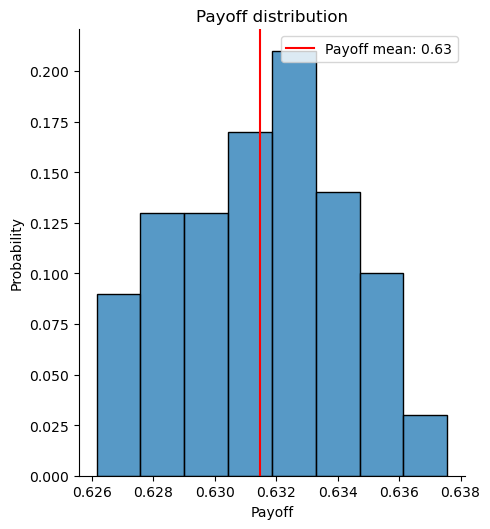

In [24]:
sns.displot(mc_estimates, stat='probability')
plt.title('Payoff distribution')
plt.xlabel('Payoff')
payoff_mean=np.mean(mc_estimates)
plt.axvline(x=payoff_mean, color="red", label="Payoff mean: "+str(round(payoff_mean, 2)))
plt.legend()
plt.show()

In [35]:
mlmc_var = 2.107e-05 # Comparison with the variance obtained for the MLMC without Brownian Bridge
mc_var = 10**10

paths = 500
times = [] 
varis = []
while mlmc_var < mc_var:
    start_time = time.process_time()
    mc_estimates = []
    for _ in range(100):
        mc_estimates.append(np.mean(standard_monte_carlo(f=payoff_call, L=3, no_of_paths=paths)))
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    average_mc_price = np.mean(mc_estimates)
    mc_var = np.var(mc_estimates)
    times.append(elapsed_time)
    varis.append(mc_var)
    print(mc_var, average_mc_price)
    print(elapsed_time)
    paths+=100

1.4034987580507945e-05 0.6269802506548455
4.495415000000094


In [34]:
mlmc_var = 1.7e-05 # Comparison with the variance obtained for the MLMC with Brownian Bridge
mc_var = 10**10

paths = 500
times = [] 
varis = []
while mlmc_var < mc_var:
    start_time = time.process_time()
    mc_estimates = []
    for _ in range(100):
        mc_estimates.append(np.mean(standard_monte_carlo(f=payoff_call, L=3, no_of_paths=paths)))
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    average_mc_price = np.mean(mc_estimates)
    mc_var = np.var(mc_estimates)
    times.append(elapsed_time)
    varis.append(mc_var)
    print(mc_var, average_mc_price)
    print(elapsed_time)
    paths+=100

1.4055249497848912e-05 0.6262837083273789
4.383796999999959
